<a href="https://colab.research.google.com/github/mlartorg/visualML/blob/master/convoca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPLORING CONVOCA

## Original code by William Gilpin

### https://arxiv.org/abs/1809.02942



## Import requirements

In [1]:
!git clone https://github.com/williamgilpin/convoca

Cloning into 'convoca'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 67 (delta 16), reused 28 (delta 7), pack-reused 27
Unpacking objects: 100% (67/67), done.


In [1]:
%cd convoca

/content/convoca


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
import glob
import pickle

import sys
sys.path.insert(0, '..')
from ca_funcs import make_glider, make_game_of_life
from utils import *
from train_ca import *


%load_ext autoreload
%autoreload 2

# Build and train a model

In [3]:
#### Make training data
tf.random.set_seed(0)

## Make training data
train_size, wspan, hspan = (100, 10, 10)
X_train = tf.convert_to_tensor(np.random.choice([0,1], (train_size, wspan, hspan), p=[.5,.5]), tf.float32)
gol = make_game_of_life()
Y_train = gol(tf.convert_to_tensor(X_train, tf.float32))

X_train = X_train[..., tf.newaxis]
Y_train = Y_train[..., tf.newaxis]


In [4]:
#### Define and build model
tf.random.set_seed(0)
layer_dims = [10, 10, 10]
num_classes = 2

try:
    del model
except:
    pass

loss = lambda x, y : tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)), 
                                                              tf.reshape(y, shape=(-1, num_classes)), 
                                                              from_logits=True)
model = initialize_model((wspan, hspan), layer_dims, num_classes=num_classes)
# model = initialize_model((wspan, hspan), [10, 10, 10, 10], num_classes=num_classes, totalistic=True, bc="periodic")
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), loss=loss)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wraparound2d (Wraparound2D)  (None, 12, 12, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 10)        100       
_________________________________________________________________
reshape (Reshape)            (None, 100, 10)           0         
_________________________________________________________________
dense (Dense)                (None, 100, 10)           110       
_________________________________________________________________
dense_1 (Dense)              (None, 100, 10)           110       
_________________________________________________________________
dense_2 (Dense)              (None, 100, 2)            22        
Total params: 342
Trainable params: 342
Non-trainable params: 0
__________________________________________________________

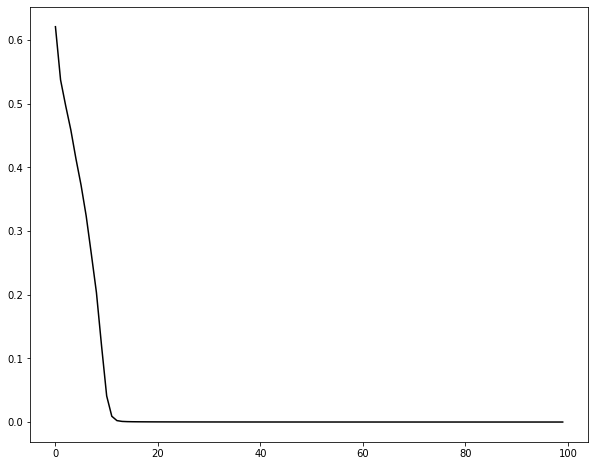

In [5]:
#### Run training
Y_train_onehot = tf.squeeze(tf.one_hot(tf.cast(Y_train, tf.int32), num_classes))
train_history = model.fit(x=X_train, y=Y_train_onehot, epochs=100, batch_size=10, verbose=0)

plt.plot(train_history.history['loss'], 'k')

Text(0.5, 1.0, 'Observed Output')

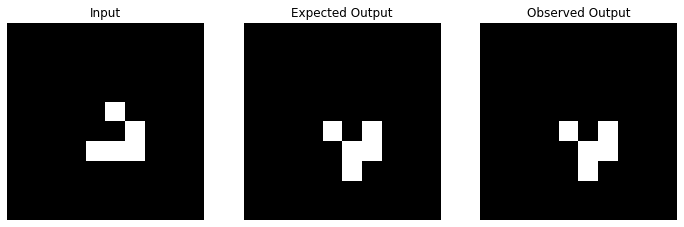

In [6]:
### Plot results

## Generate testing data
X_test = tf.convert_to_tensor(np.moveaxis(np.dstack([make_glider(10), make_glider(10)]), 2, 0), tf.float32)
# X_test = tf.convert_to_tensor(make_glider(10), tf.float32)[tf.newaxis, ...]
Y_test = gol(X_test)
X_test = X_test[..., tf.newaxis]
Y_test = Y_test[..., tf.newaxis]

Y_pred = logit_to_pred(model(X_test), shape=(-1, wspan, hspan))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(tf.squeeze(X_test[0]))
plt.axis('off')
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(tf.squeeze(Y_test[0]))
plt.axis('off')
plt.title("Expected Output")

plt.subplot(1,3,3)
plt.imshow(tf.squeeze(Y_pred[0]))
plt.axis('off')
plt.title("Observed Output")



In [7]:
### Save and load a model
model.save('path_to_my_model.h5')
# del model
# model = tf.keras.models.load_model('path_to_my_model.h5', custom_objects={'Wraparound2D': Wraparound2D})

# run model for a few steps

In [8]:
from PIL import Image

def imshow(x, size=(512, 512)):
    return Image.fromarray(tf.squeeze(x).numpy().astype('uint8') * 255 ).resize(size, Image.NEAREST)

In [22]:
def model_step(x):
    return tf.expand_dims(logit_to_pred(model(x), shape=(-1, wspan, hspan)), -1)

def gol_step(x):
    return gol(x)

In [42]:
!mkdir frames
!rm frames/*

mkdir: cannot create directory ‘frames’: File exists


In [70]:
def make_pad(size):
    return np.pad(np.zeros((size-2, size-2)), 1, constant_values=1)

def random_init(size):
    return np.random.choice([0, 1], (size, size))

In [79]:
x = tf.convert_to_tensor(np.moveaxis(np.dstack([make_glider(10), make_glider(10)]), 2, 0), tf.float32)
y = tf.convert_to_tensor(np.moveaxis(np.dstack([make_glider(10), make_glider(10)]), 2, 0), tf.float32)

x = tf.convert_to_tensor(np.moveaxis(np.dstack([make_pad(10), make_pad(10)]), 2, 0), tf.float32)
y = tf.convert_to_tensor(x)


iw = random_init(10)
x = tf.convert_to_tensor(np.moveaxis(np.dstack([iw, iw]), 2, 0), tf.float32)
y = tf.convert_to_tensor(x)

In [80]:
for i in range(100):
    x = model_step(x)
    y = gol_step(y)

    # plt.imsave('frames/frame{:05d}.jpg'.format(i), tf.squeeze(x[0]))
    # imshow(x).save('frames/frame{:05d}.jpg'.format(i))
    imshow(np.hstack([x[0], tf.expand_dims(y, -1)[0]]), (512*2, 512)).save('frames/frame{:05d}.jpg'.format(i))

In [81]:
!ffmpeg -pattern_type glob -i "frames/*.jpg" -r 8 movie.mp4 -y -loglevel quiet

In [82]:
from moviepy.editor import *

clip = VideoFileClip("movie.mp4")

clip.ipython_display(height=512)

 97%|█████████▋| 34/35 [00:00<00:00, 127.46it/s]


# Show activation patterns of hidden layers

Text(0.5, 1.0, 'Convolutional filters')

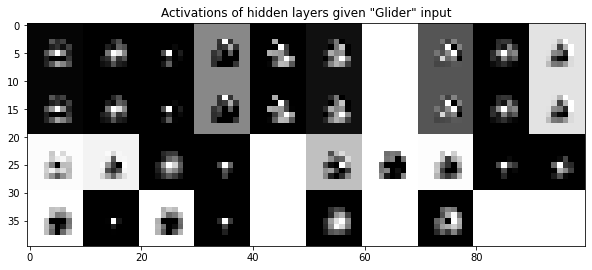

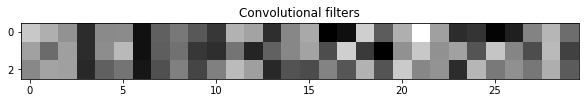

In [110]:
import tensorflow.keras.backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function(inp, outputs)   # evaluation function

layer_outs = functor([X_test, 1.])



# Plot activations of different neurons in different layers 
all_layer_activations = list()

min_max_scaler = lambda x : (x - np.min(x))/(np.max(x) - np.min(x))
# min_max_scaler = lambda x : (x - np.mean(x))
for j in range(1, 5):
    if j==1:
        layer_im = np.hstack([min_max_scaler(layer_outs[1][0][..., i]) for i in range(10)])
    else:
        pattern = np.reshape(layer_outs[j][0], (wspan, hspan, -1))
        layer_im = np.hstack([min_max_scaler(pattern[..., i]) for i in range(10)])
    all_layer_activations.append(layer_im)

        
plt.figure()
plt.imshow(np.vstack(all_layer_activations))
plt.title("Activations of hidden layers given \"Glider\" input")

plt.figure()
plt.imshow(np.squeeze(np.dstack(model.layers[1].weights[0].numpy())))
plt.title("Convolutional filters")